In [3]:
import robustats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from numba import njit

sns.set_style("whitegrid")

## Question 3

### 1. (a)

#### Helper Functions

In [4]:
def load_data():
    df = pd.read_stata("data/rscfp2019.dta")
    df = df[["wgt", "age", "income", "networth"]].rename(
        columns={"wgt": "weight", "networth": "wealth",},
    )
    return df

In [5]:
def weighted_median(df, value_col, weight_col="weight"):
    median = robustats.weighted_median(df[value_col].values, df[weight_col].values)
    return median

In [6]:
def time_to_age(time):
    return time + 24

In [493]:
def rolling_weighted_median(df, last_period, left_window, right_window):

    results = pd.DataFrame(columns=["age", "income", "wealth"], dtype=float).set_index("age")
    for time in range(1, last_period+1):
        age = time_to_age(time)
        left = age - left_window
        right = age + right_window

        data = df.query("@left <= age <= @right")

        income = weighted_median(data, value_col="income")
        wealth = weighted_median(data, value_col="wealth")

        results.loc[age, :] = (income, wealth)

    results["ratio"] = results["wealth"] / results["income"]
    return results

#### Computation

In [78]:
df = load_data()

In [494]:
median = rolling_weighted_median(df, last_period=60, left_window=2, right_window=2)

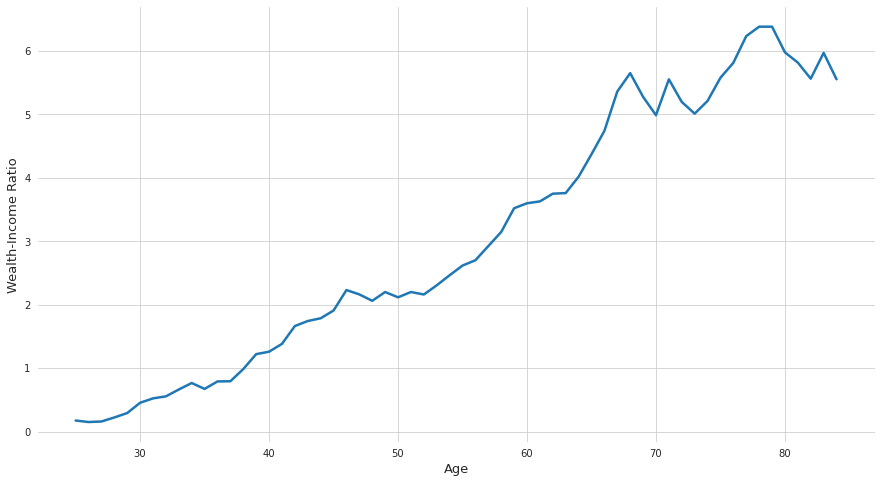

In [499]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 8)

sns.lineplot(data=median, x="age", y="ratio", ax=ax, linewidth=2.5)
ax.set_frame_on(False)
ax.set(ylabel="Wealth-Income Ratio", xlabel="Age")
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)

plt.show()

### 1. (b)

In [500]:
def normalize_income(df):
    """Normalize income between age 25 - 64."""
    df = df.copy()
    average = df.query("25 <= age < 65")["income"].mean()
    df.loc[:, ("income", "wealth")] /= average
    return df

In [501]:
def income_stream(normalized_df, tau=0.5):
    normalized_income = normalized_df["income"][:64]
    pension = pd.Series(20 * [tau], index=range(65, 85))
    stream = normalized_income.append(pension).values
    return stream

In [502]:
def wealth_stream(normalized_df, tau=0.5):
    normalized_wealth = normalized_df["wealth"].values
    return normalized_wealth

In [503]:
normalized = normalize_income(median)

In [504]:
income_array = income_stream(normalized)

In [544]:
n_grid_points = 500
max_periods = 60
interest = 0.04
beta = 0.96
wealth_grid = np.linspace(0, 25, n_grid_points)

In [545]:
def consumption(old_wealth, new_wealth, income, interest):
    consum = income + (1 + interest) * old_wealth - new_wealth
    return consum

In [546]:
def utility_func(consum):
    illegal = consum < 10e-7
    consum[illegal] = 1
    utility = np.log(consum)
    utility[illegal] = -np.inf
    return utility

In [547]:
def _internal_backwards_induction(
    wealth_grid, income_array, interest, beta
):
    """Internal backwards induction over value functions.
    
    Args:
        wealth_grid (np.ndarray or list-like): List of discretized wealth
            values of which we optimize.
    
    """
    value_array = np.zeros((max_periods+1, len(wealth_grid)))
    policy_index = np.empty((max_periods, len(wealth_grid)))

    for t in reversed(range(max_periods)):

        # algorithm:
        for j, wealth in enumerate(wealth_grid):
            old_values = value_array[t+1, :]
            
            consum = consumption(wealth, wealth_grid, income_array[t], interest)
            utility  = utility_func(consum)
            to_max = utility + beta * old_values
            argmax = np.argmax(to_max)
            value_array[t, j] = to_max[argmax]
            policy_index[t, j] = argmax
            
        # update policy func
        if t != max_periods - 1:
            for j in range(max_periods-t-1):
                tmp = policy_index[1+t+j, :]
                policy_index[1 + t + j, :] = tmp[policy_index[t+1, :].astype(int)]

    return policy_index

In [548]:
pol = _internal_backwards_induction(wealth_grid, income_array, interest, beta)

In [549]:
policy = wealth_grid[pol.astype(int)]

In [550]:
policy_profile = np.zeros(max_periods + 1, dtype=int)
policy_profile[0] = 4

In [551]:
for t in range(max_periods):
    policy_profile[t+1] = pol[t, policy_profile[t]]

In [558]:
values = wealth_grid[policy_profile][1:] / income_array / 2
axis = np.arange(len(values)) + 1

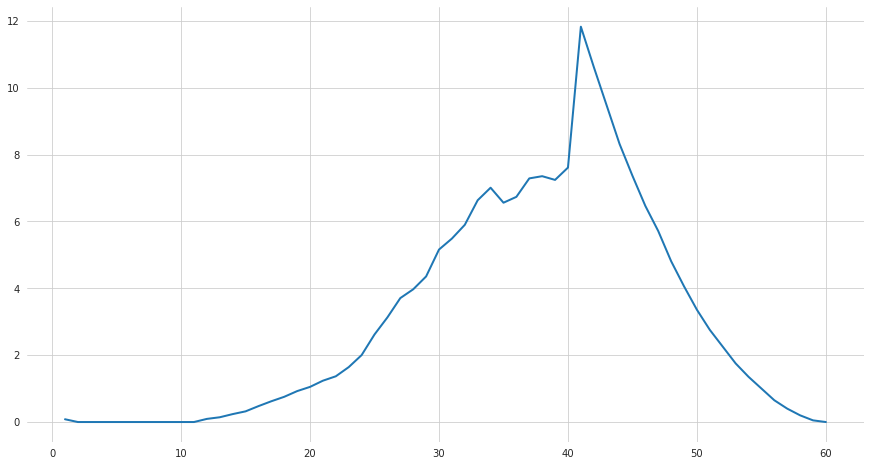

In [559]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 8)

sns.lineplot(x=axis, y=values, ax=ax, linewidth=2)
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)

plt.show()